# Images of lego bricks classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## The dataset

This notebook uses a dataset of about 6379 photos of lego parts from this link https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images/data. The dataset contains five sub-directories, one per class:

```
LEGO_brick_images\
	11214_Bush_3M_friction_with_Cross_axle\
	18651_Cross_Axle_2M_with_Snap_friction\
	2357_Brick_corner_1x2x2\
	3003_Brick_2x2\
	3004_Brick_1x2\
	3005_Brick_1x1\
	3022_Plate_2x2\
	3023_Plate_1x2\
	3024_Plate_1x1\
	3040_Roof_Tile_1x2x45deg\
	3069_Flat_Tile_1x2\
	32123_half_Bush\
	3673_Peg_2M\
	3713_Bush_for_Cross_Axle\
	6632_Technic_Lever_3M\
   
```

In [2]:
data_dir = 'Datasets\LEGO_brick_images'
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

6379


Here are some bricks corner 1x2x2:

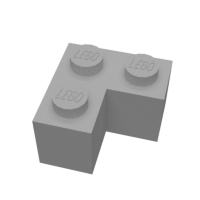

In [4]:
brick_corner_1x2x2 = list(data_dir.glob('2357_Brick_corner_1x2x2/*'))
PIL.Image.open(str(brick_corner_1x2x2[0]))

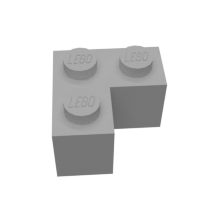

In [5]:
PIL.Image.open(str(brick_corner_1x2x2[1]))

And some bricks 2x2:

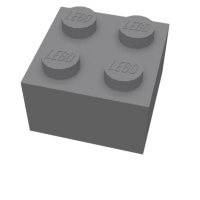

In [6]:
brick_2x2 = list(data_dir.glob('3003_Brick_2x2/*'))
PIL.Image.open(str(brick_2x2[0]))

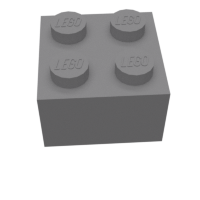

In [7]:
PIL.Image.open(str(brick_2x2[1]))

### Create a dataset

In [8]:
batch_size = 32
img_height = 360
img_width = 360

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=2137,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6379 files belonging to 16 classes.
Using 5104 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=2137,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6379 files belonging to 16 classes.
Using 1275 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['11214_Bush_3M_friction_with_Cross_axle', '18651_Cross_Axle_2M_with_Snap_friction', '2357_Brick_corner_1x2x2', '3003_Brick_2x2', '3004_Brick_1x2', '3005_Brick_1x1', '3022_Plate_2x2', '3023_Plate_1x2', '3024_Plate_1x1', '3040_Roof_Tile_1x2x45deg', '3069_Flat_Tile_1x2', '32123_half_Bush', '3673_Peg_2M', '3713_Bush_for_Cross_Axle', '3794_Plate_1X2_with_1_Knob', '6632_Technic_Lever_3M']


## Visualize the data

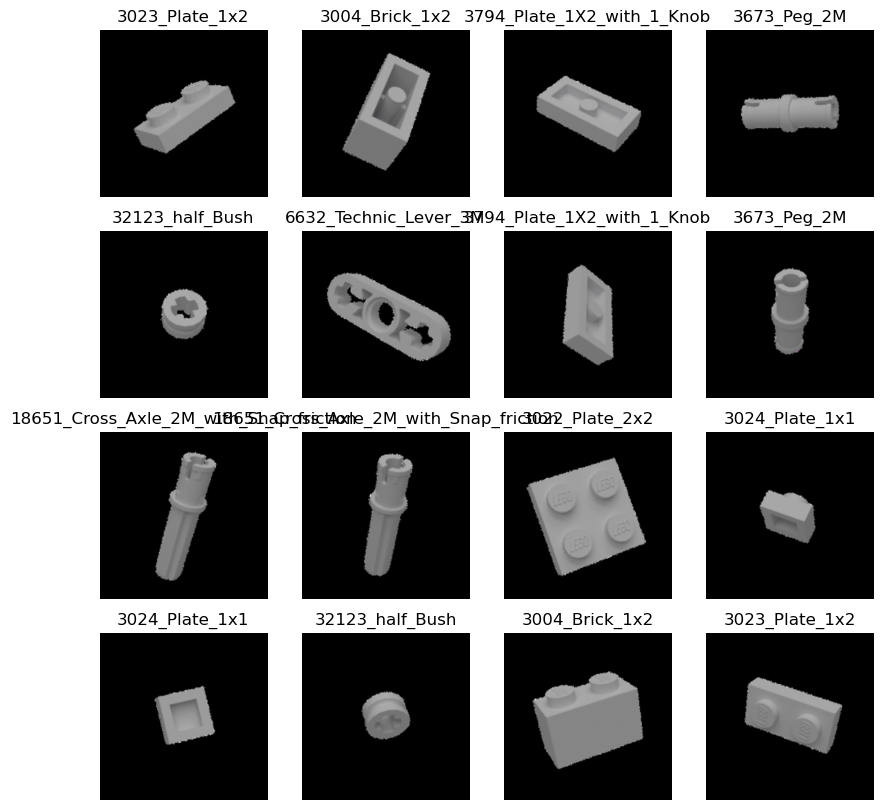

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9015245


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
num_classes = len(class_names)

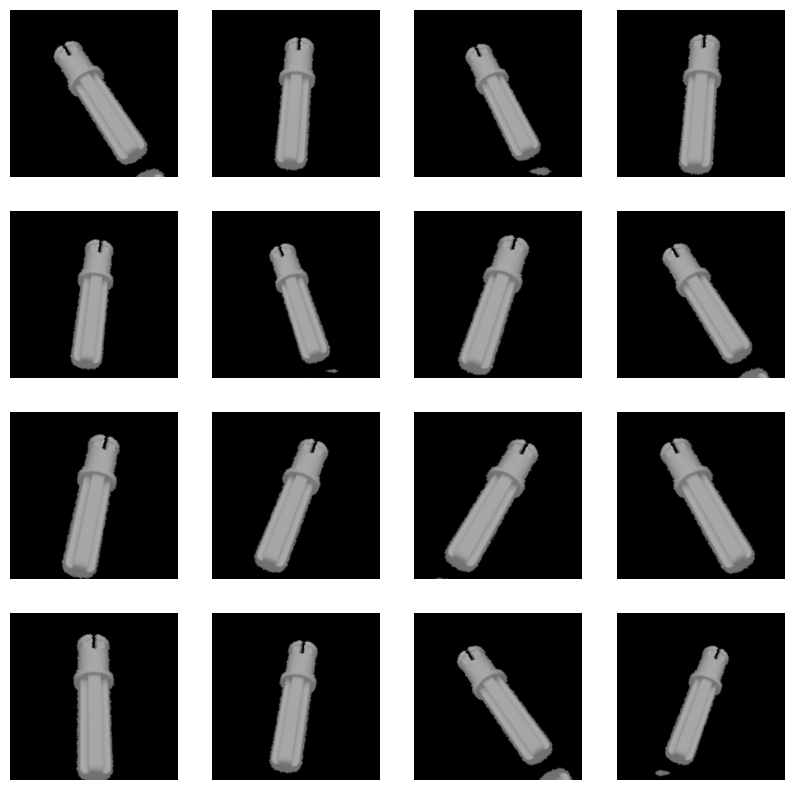

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 360, 360, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 360, 360, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 360, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 180, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
160/160 [==============================] - 36s 198ms/step - loss: 1.2470 - accuracy: 0.5647 - val_loss: 0.6697 - val_accuracy: 0.7404
Epoch 2/25
160/160 [==============================] - 24s 151ms/step - loss: 0.7178 - accuracy: 0.7461 - val_loss: 0.4581 - val_accuracy: 0.8353
Epoch 3/25
160/160 [==============================] - 17s 106ms/step - loss: 0.5621 - accuracy: 0.7937 - val_loss: 0.3831 - val_accuracy: 0.8604
Epoch 4/25
160/160 [==============================] - 19s 117ms/step - loss: 0.4619 - accuracy: 0.8311 - val_loss: 0.3210 - val_accuracy: 0.8761
Epoch 5/25
160/160 [==============================] - 34s 212ms/step - loss: 0.4016 - accuracy: 0.8552 - val_loss: 0.2824 - val_accuracy: 0.9067
Epoch 6/25
160/160 [==============================] - 35s 219ms/step - loss: 0.3311 - accuracy: 0.8779 - val_loss: 0.2337 - val_accuracy: 0.9090
Epoch 7/25
160/160 [==============================] - 30s 185ms/step - loss: 0.2932 - accuracy: 0.8962 - val_loss: 0.1832 - val_ac

## Visualize training results


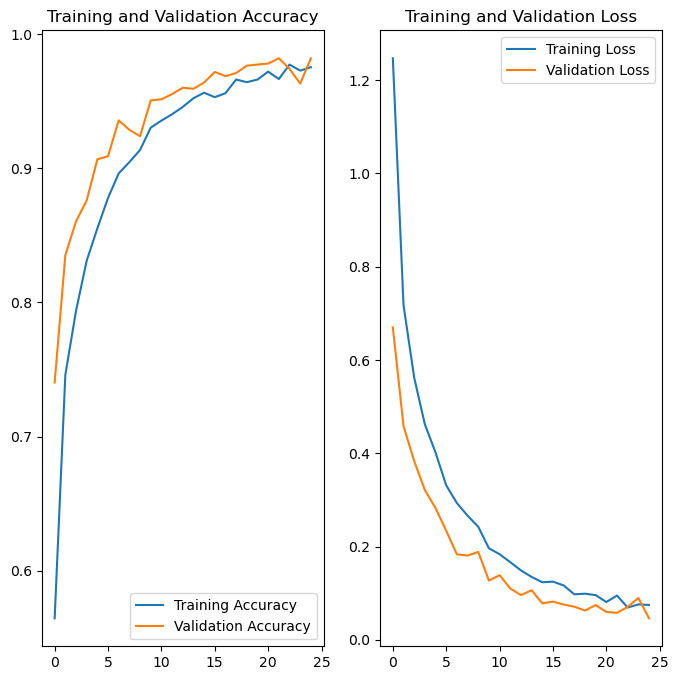

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [49]:

brick_1x1_path = 'Datasets/LEGO_new/3005_Brick_1x1/0014.png'
img = tf.keras.utils.load_img(
    brick_1x1_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 3005_Brick_1x1 with a 99.98 percent confidence.


In [48]:
peg_2m_path = 'Datasets/LEGO_new/3673_Peg_2M/0002.png'
img = tf.keras.utils.load_img(
    peg_2m_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 3794_Plate_1X2_with_1_Knob with a 85.35 percent confidence.


## Use TensorFlow Lite
TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.


### Convert the Keras Sequential model to a TensorFlow Lite model

In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\MACIEJ\AppData\Local\Temp\tmpfqdmeplt\assets


INFO:tensorflow:Assets written to: C:\Users\MACIEJ\AppData\Local\Temp\tmpfqdmeplt\assets


In [53]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)


In [54]:
interpreter.get_signature_list()
{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In [55]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [56]:
predictions_lite = classify_lite(sequential_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [57]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to 3005_Brick_1x1 with a 99.98 percent confidence.


In [58]:
print(np.max(np.abs(predictions - predictions_lite)))

0.001045227
